# Convolutional Network Classifier: Nike vs Adidas Shoes

The objective of this little project will be to build an image classifier that would distinguish between Nike and Adidas basketball shoes.

__Datasat and project idea by [Connor Shorten](
https://github.com/CShorten?tab=repositories), part of the #100DaysOfMLCode challenge.__

![nike_vs_adidas](misc/nike_vs_adidas.jpg)

___
<br>

__1/ Let's begin by taking a quick look at the dataset we have:__

In [1]:
# Importing required libraries
import numpy as np
import os
from random import shuffle
from tqdm import tqdm   #Instantly make your loops show a smart progress meter
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
TRAIN_DIR = 'TRAIN'
TEST_DIR = 'TEST'

IMG_SIZE = 120
LR = 1e-3

MODEL_NAME = 'NIKEvsADIDAS--{}-{}.model'.format(LR, '2conv-basic')

In [3]:
def label_img(img):
    # Images are formatted as: ADIDAS_1, NIKE_3 ...
    word_label = img.split('_')[0]
    if word_label == 'NIKE': return [1,0] #one hot encoding
    elif word_label == 'ADIDAS': return [0,1] #one hot encoding

In [4]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        ############################################################
        #    This part is different from sentdex's tutorial
        # Chose to use PIL instead of cv2 for image pre-processing
        ############################################################
        
        img = Image.open(path) #Read image syntax with PIL Library
        img = img.convert('L') #Grayscale conversion with PIL library
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS) #Resizing image syntax with PIL Library
        
        ############################################################
        
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data) #.npy extension = numpy file
    return train_data


In [5]:
def process_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            img_num = img.split('_')[1] #images are formatted 'NIKE_2', 'ADIDAS_56'..
        
            #PIL LIBRARY instead of cv2
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
            test_data.append([np.array(img), img_num])
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    return test_data

100%|██████████| 100/100 [00:00<00:00, 180.24it/s]


[1 0]


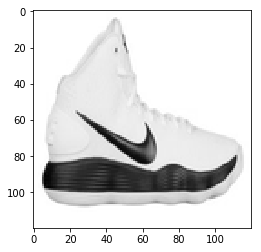

In [6]:
train_data = create_train_data()
plt.imshow(train_data[43][0], cmap = 'gist_gray')
print(train_data[43][1])

In [10]:
!pip3 install tflearn

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_verbose=3)

/Users/eliottjoulot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
# DATA SPLITTING
# Data splitting is typically done 80% train and 20% test
# of the 80% of our data in the train set
# we set aside a small percentage as a validation set
# this is used to do parameter tuning before evaluating
# on our test set

train = train_data[-90:] #Train Set
test = train_data[:-90] #Validation Set

In [12]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [ ]:
model.fit({'input': X}, {'targets': Y}, n_epoch=100, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=50, show_metric=True, run_id='NIKE_ADIDAS')

Training Step: 163  | total loss: 0.50835 | time: 1.737s
| Adam | epoch: 082 | loss: 0.50835 - acc: 0.8270 -- iter: 64/90


In [ ]:
test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:10]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    print(model_out)
    if np.argmax(model_out) == 1:
        str_label = 'ADIDAS'
    else:
        str_label = 'NIKE'
    
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()